In [203]:
import pandas as pd
import torch
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings

In [204]:
import sqlite3
con = sqlite3.connect("/kaggle/input/flipkart-cell-phone-reviews/flipkart_products.db")
items = pd.read_sql_query("SELECT * from items", con)
con.close()

In [205]:
print(items.tail())
print(items.info())

    product_id                     product_name    price     category  \
77  ECMB000078   Redmi 7 (Eclipse Black, 32 GB)   ₹8,390  Electronics   
78  ECMB000079  Mi A3 (More Than White, 128 GB)  ₹17,499  Electronics   
79  ECMB000080           Redmi Y2 (Blue, 64 GB)  ₹13,499  Electronics   
80  ECMB000081       Redmi 5 (Lake Blue, 64 GB)   ₹8,299  Electronics   
81  ECMB000082    Mi A3 (Not just Blue, 128 GB)  ₹17,499  Electronics   

   sub_category  \
77       Mobile   
78       Mobile   
79       Mobile   
80       Mobile   
81       Mobile   

                                                                                                                                                                                                                                       specifications  \
77   3 GB RAM | 32 GB ROM | Expandable Upto 512 GB15.9 cm (6.26 inch) HD+ Display12MP + 2MP | 8MP Front Camera4000 mAh BatteryQualcomm Snapdragon 632 ProcessorBrand Warranty of 1 Year Available for

In [206]:
con = sqlite3.connect("/kaggle/input/flipkart-cell-phone-reviews/flipkart_products.db")

df = pd.read_sql_query("SELECT * from ECMB000001", con)

for i in range(2, len(items) + 1):

    df_temp = pd.read_sql_query("SELECT * from ECMB{:06d}".format(i), con)
    df = pd.concat([df, df_temp])
con.close()

/opt/conda/lib/python3.7/site-packages/missingno/missingno.py:72: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
/opt/conda/lib/python3.7/site-packages/missingno/missingno.py:141: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


<Figure size 576x576 with 0 Axes>

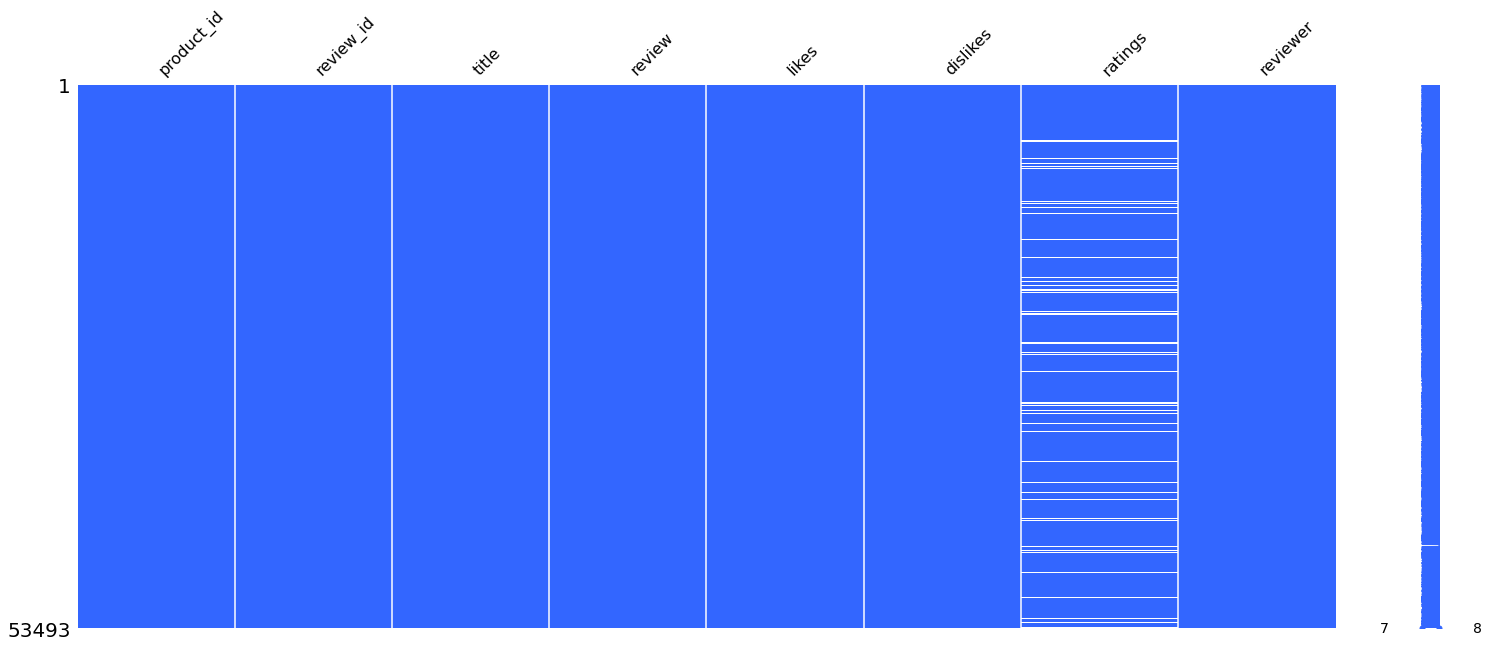

In [207]:
import missingno as msno
plt.figure(figsize=(8, 8))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()

In [208]:
df.dropna(inplace=True, axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48488 entries, 0 to 287
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  48488 non-null  object
 1   review_id   48488 non-null  object
 2   title       48488 non-null  object
 3   review      48488 non-null  object
 4   likes       48488 non-null  object
 5   dislikes    48488 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    48488 non-null  object
dtypes: object(8)
memory usage: 3.3+ MB


/opt/conda/lib/python3.7/site-packages/missingno/missingno.py:72: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
/opt/conda/lib/python3.7/site-packages/missingno/missingno.py:141: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


<Figure size 1800x1440 with 0 Axes>

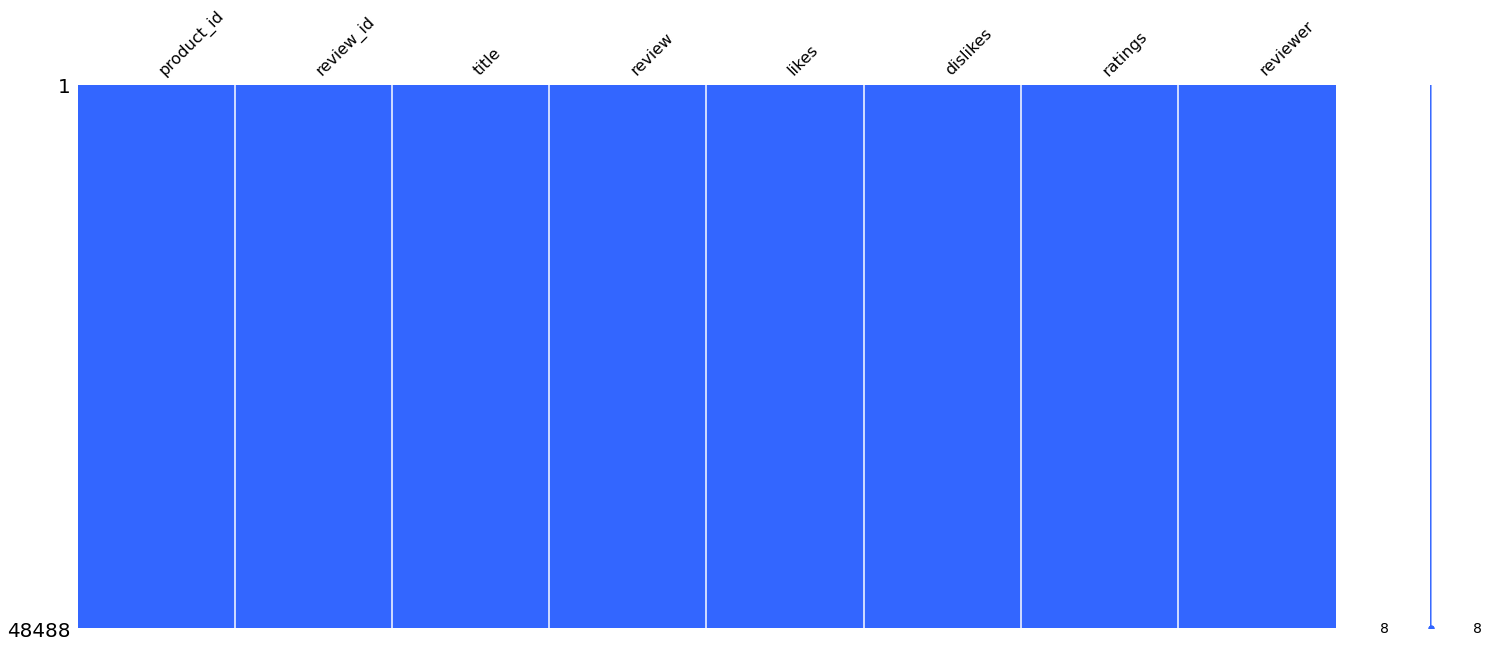

In [209]:
import missingno as msno
plt.figure(figsize=(25, 20))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()

In [210]:
import re

def remove_url(text):
    text = re.sub(r"http\S+", "", text)
    return text

In [211]:
!pip install demoji

In [212]:
import demoji


def handle_emoji(string):
    emojis = demoji.findall(string)

    for emoji in emojis:
        string = string.replace(emoji, " " + emojis[emoji].split(":")[0])

    return string

In [213]:
def word_tokenizer(text):
    text = text.lower()
    text = text.split()

    return text

In [214]:
stop_w = {"isn't", 'there', 'should', "that'll", "don't", 'am', 'its', 'been', 't', 'out', 'under', 'same', 'any', 'for', 'ain', 'won', 'between', 'have', "you'd", 'only', 'your', 'who', 'shan', "you're", 'by', 'it', 'yourself', 'o', 'isn', "should've", 'to', 'were', 'can', 'his', 'an', 'we', 'her', "you'll", 'into', 'such', 'very', 'shouldn', 'when', 'themselves', 'off', 'll', 'myself', "you've", 'nor', 'what', 'down', 'himself', 'does', 'mightn', 'yours', 'hers', 'while', 'wouldn', 'than', "wasn't", 'until', 've', 'do', 'didn', 'whom', 'needn', 'you', "aren't", 'm', 'him', 'each', 'are', 'will', 'again', 'them', 'doing', "needn't", 'had', 'she', 'the', "wouldn't", 'just', 'at', 'from', 'how', 'they', 'some', 'those', 'where', 'through', 'this', 'then', 'over', 'why', 'couldn', 'ourselves', 'hadn', 'which', 'further', 'now', 'ours', 'aren', 'be', 'hasn', 'other', 'above', 'about', 'up', 'own', 'a', 'don', 'was', 'that', 'wasn', 's', "couldn't", "hasn't", 'their', 'all', 'because', 'being', 'has', 'theirs', 'and', 'too', 're', 'did', 'y', "hadn't", 'most', "haven't", 'below', 'before', "doesn't", 'in', 'once', 'weren', 'during', 'on', 'these', 'haven', "weren't", 'against', 'of', "shan't", 'here', "mustn't", 'mustn', 'yourselves', 'our', 'if', 'my', "didn't", 'or', 'having', 'as', 'but', 'both', "mightn't", "it's", 'herself', 'd', 'no', 'so', 'he', 'few', 'doesn', 'itself', 'me', 'ma', 'not', 'i', "she's", 'after', 'is', "shouldn't", "won't", 'with', 'more'}

In [215]:
def remove_stopwords(text):
    text = [word for word in text if word not in stop_w]
    return text

In [216]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

stemmer = PorterStemmer()
# stemmer = LancasterStemmer()


def stemming(text):

    text = [stemmer.stem(word) for word in text]
    return text


sample = "I am creating a Notebook"
print(f"Before Stemming : {(sample)}")
print(f"After Stemming : {stemming(word_tokenizer(sample))}")


Before Stemming : I am creating a Notebook
After Stemming : ['i', 'am', 'creat', 'a', 'notebook']


In [217]:
import spacy

sp = spacy.load("en_core_web_sm")

In [218]:
def lemmatization(text):

    # text = [sp(word).lemma_ for word in text]

    text = " ".join(text)
    token = sp(text)

    text = [word.lemma_ for word in token]
    return text


print(f"Before Lemmatization : {word_tokenizer(sample)}")
print(f"After Lemmatization : {lemmatization(word_tokenizer(sample))}")

Before Lemmatization : ['i', 'am', 'creating', 'a', 'notebook']
After Lemmatization : ['I', 'be', 'create', 'a', 'notebook']


In [219]:
!pip install langdetect

In [220]:
from langdetect import detect


en_text = u""""Hi Everyone I am Ankit Gupta."""
print(f" {en_text} : {detect(en_text)}")

hindi_text = u"""मेरा नाम अंकित गुप्ता है और मैं एक छात्र हूँ"""
print(f"{hindi_text} : {detect(hindi_text)}")

 "Hi Everyone I am Ankit Gupta. : tl
मेरा नाम अंकित गुप्ता है और मैं एक छात्र हूँ : hi


In [221]:
df_temp = df.copy()
# Assigning labels to each review

def label(y):
    if y == '5':
        return 1
    elif y == '4':
        return 1
    else:
        return 0
    
from tqdm import tqdm

tqdm.pandas()

df_temp['y'] = df_temp.ratings.progress_map(label)

df_temp = df_temp[['review', 'y', 'ratings']]

df_temp.tail()

100%|██████████| 48488/48488 [00:00<00:00, 609954.33it/s]


,review,y,ratings
280,Product is fine and durable.,1,4
284,Nice,1,4
285,Very nice phone,1,5
286,Amazing phone with great Performance..,1,5
287,"There is some problems , sometimes keep restarting automatically",1,5


In [222]:
df_temp2 = df_temp2 = df_temp[(df_temp['ratings'] == '5')]

In [223]:
positive = list(df_temp2[(df_temp2['review'].str.len() > 100) & (df_temp2['review'].str.len() < 350)]['review'])
len(positive)

4803

In [224]:
!pip install nlpaug

In [225]:
import nlpaug.augmenter.word as naw

In [226]:
aug = naw.AntonymAug(name='Antonym_Aug', aug_min=1, aug_max=10, aug_p=0.3, lang='eng', stopwords=stop_w, tokenizer=None, 
                     reverse_tokenizer=None, stopwords_regex=None, verbose=0)
 
aug_negative = aug.augment(positive)

In [227]:
df_negative = pd.DataFrame({"review" : aug_negative, 'y' : [0]*len(aug_negative)})
df_positive = pd.DataFrame({"review" : positive, 'y' : [1]*len(positive)})

In [228]:
df_temp = pd.concat([df_negative, df_positive]).sample(frac = 1, random_state = 11).reset_index(drop=True)

In [229]:
df1 = df_temp

In [230]:
import unicodedata as uni
def preprocessing(text):
    
    text = remove_url(text) 
    text = uni.normalize('NFKD', text)
    text = handle_emoji(text)
    text = text.lower() 
    text = re.sub(r'[^\w\s]', '', text)
    text = word_tokenizer(text)
    # text = stemming(text)
    text = lemmatization(text)
    text = remove_stopwords(text)
    text = " ".join(text)

    return text

In [231]:
from tqdm import tqdm

tqdm.pandas()

df1['clean_review'] = df1['review'].progress_map(preprocessing)

100%|██████████| 9606/9606 [01:57<00:00, 81.94it/s]


In [232]:
reviews = df1.clean_review.values.tolist()

In [233]:
tqdm.pandas()

df1['clean_review2'] = df1['clean_review'].progress_map(word_tokenizer)

100%|██████████| 9606/9606 [00:00<00:00, 208837.98it/s]


In [234]:
data_words = df1['clean_review2'].values.tolist()
len(data_words)

9606

In [235]:
import gensim
data = list(df1['clean_review'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['great', 'phone', 'budget', 'pubg', 'performance', 'staccato', 'camera', 'worsen', 'old', 'update', 'ni', 'mode', 'cam', 'aadde', 'phone', 'also', 'evil', 'stupid', 'phone']]


In [236]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['great', 'phone', 'budget', 'pubg', 'performance', 'staccato', 'camera', 'worsen', 'old', 'update', 'ni', 'mode', 'cam', 'aadde', 'phone', 'also', 'evil', 'stupid', 'phone']


In [237]:
import nltk
nltk.download('stopwords')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [238]:
from gensim.utils import simple_preprocess
import spacy

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#from spacy_download import load_spacy
#nlp = load_spacy("en_core_web_sm", exclude=["parser", "tagger"])  # Will download the model if it isn't installed yet
!python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
[['great', 'phone', 'budget', 'performance', 'camera', 'old', 'update', 'phone', 'also', 'evil', 'stupid', 'phone']]


In [239]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]


In [240]:
from gensim.models.coherencemodel import CoherenceModel
for i in range(4,11):
    lsi_model=gensim.models.lsimodel.LsiModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=i, 
                                               chunksize=100
                                               )
    coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lsi = coherence_model_lsi.get_coherence()


    print('\nCoherence Score of n_topics1 {}: {}'.format(i,coherence_lsi))

/opt/conda/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/opt/conda/lib/python3.7/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))



Coherence Score of n_topics1 4: nan

Coherence Score of n_topics1 5: 0.32539421758381887

Coherence Score of n_topics1 6: nan

Coherence Score of n_topics1 7: 0.3163930711513667

Coherence Score of n_topics1 8: 0.3296082866147523

Coherence Score of n_topics1 9: 0.3167674855836135

Coherence Score of n_topics1 10: 0.3047444398281197


In [241]:

from gensim.models.coherencemodel import CoherenceModel
# Compute Perplexity
for i in range(4,11):
    from gensim.models import LdaMulticore
    from gensim.models import LdaModel
    from pprint import pprint
    # Build LDA model
    lda_model = LdaMulticore(corpus=corpus, id2word=id2word,
                         num_topics=i, iterations=400)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    print('\nCoherence Score of topic {}:{} '.format(i,coherence_lda))


Coherence Score of topic 4:0.24955822503243147 

Coherence Score of topic 5:0.25810550423054524 

Coherence Score of topic 6:0.24249595682437133 

Coherence Score of topic 7:0.2524783569885827 

Coherence Score of topic 8:0.26327886052208715 

Coherence Score of topic 9:0.25972895025807663 

Coherence Score of topic 10:0.26729066631295983 


In [242]:
 # Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.029*"good" + 0.028*"camera" + 0.021*"phone" + 0.019*"product" + '
  '0.018*"bad" + 0.014*"evil" + 0.013*"mobile" + 0.013*"performance" + '
  '0.012*"sell" + 0.012*"battery"'),
 (1,
  '0.041*"good" + 0.035*"camera" + 0.028*"phone" + 0.020*"evil" + '
  '0.020*"performance" + 0.019*"battery" + 0.017*"bad" + 0.015*"quality" + '
  '0.014*"nice" + 0.014*"product"'),
 (2,
  '0.059*"phone" + 0.032*"good" + 0.031*"camera" + 0.024*"battery" + '
  '0.021*"awesome" + 0.015*"flipkart" + 0.014*"bad" + 0.013*"evil" + '
  '0.012*"performance" + 0.012*"thank"'),
 (3,
  '0.063*"phone" + 0.024*"bad" + 0.023*"camera" + 0.018*"good" + '
  '0.016*"battery" + 0.016*"great" + 0.015*"excellent" + 0.014*"redmi" + '
  '0.012*"use" + 0.011*"price"'),
 (4,
  '0.022*"product" + 0.021*"bad" + 0.020*"phone" + 0.016*"camera" + '
  '0.015*"mobile" + 0.013*"great" + 0.013*"good" + 0.012*"thank" + '
  '0.012*"awesome" + 0.012*"battery"'),
 (5,
  '0.046*"phone" + 0.039*"good" + 0.025*"product" + 0.020*"flipkart"

In [243]:
!pip install pyLDAvis

In [244]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
#import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.001635 -0.020663       1        1  15.731580
5      0.000420  0.013968       2        1  15.189279
7     -0.005473 -0.004981       3        1  13.364076
1     -0.013474 -0.014316       4        1  11.713846
9     -0.008124 -0.022644       5        1  11.375760
3     -0.009248 -0.034589       6        1  10.638706
6      0.034631  0.056007       7        1   5.927037
0     -0.076405  0.006667       8        1   5.648355
4      0.007309  0.057614       9        1   5.231544
8      0.068729 -0.037063      10        1   5.179817, topic_info=                 Term         Freq        Total Category  logprob  loglift
11              phone  7906.000000  7906.000000  Default  30.0000  30.0000
19                bad  3175.000000  3175.000000  Default  29.0000  29.0000
5                evil  2492.000000  2492.000000  Default  28.0000  28.0000
76            product  2346.000000  2346.000000  Default  27.0000  27.0000
140              face  1394.000000  1394.000000  Default  26.0000  26.0000
152             smile  1015.000000  1015.000000  Default  25.0000  25.0000
124           amazing  1067.000000  1067.000000  Default  24.0000  24.0000
80               good  5916.000000  5916.000000  Default  23.0000  23.0000
51             mobile  2438.000000  2438.000000  Default  22.0000  22.0000
4              camera  5175.000000  5175.000000  Default  21.0000  21.0000
53               nice  1437.000000  1437.000000  Default  20.0000  20.0000
6               great  1725.000000  1725.000000  Default  19.0000  19.0000
387         hearteyes   339.000000   339.000000  Default  18.0000  18.0000
299              hand   736.000000   736.000000  Default  17.0000  17.0000
64              heart   540.000000   540.000000  Default  16.0000  16.0000
1                also  1683.000000  1683.000000  Default  15.0000  15.0000
46           delivery  1273.000000  1273.000000  Default  14.0000  14.0000
12               pubg   527.000000   527.000000  Default  13.0000  13.0000
68             really  1039.000000  1039.000000  Default  12.0000  12.0000
57            awesome  2223.000000  2223.000000  Default  11.0000  11.0000
54              redmi  1643.000000  1643.000000  Default  10.0000  10.0000
25               note   872.000000   872.000000  Default   9.0000   9.0000
470              sell   839.000000   839.000000  Default   8.0000   8.0000
117                ok   676.000000   676.000000  Default   7.0000   7.0000
28              price  2653.000000  2653.000000  Default   6.0000   6.0000
41              money  1520.000000  1520.000000  Default   5.0000   5.0000
10        performance  2301.000000  2301.000000  Default   4.0000   4.0000
95          excellent  1095.000000  1095.000000  Default   3.0000   3.0000
115             nasty   920.000000   920.000000  Default   2.0000   2.0000
118               one  1149.000000  1149.000000  Default   1.0000   1.0000
2579        handshake    13.655434    14.591072   Topic1  -7.6909   1.7832
4551              rly     9.418744    10.354424   Topic1  -8.0623   1.7548
4076            catch    10.691809    12.388509   Topic1  -7.9355   1.7022
2401             wowi     5.595028     6.530600   Topic1  -8.5831   1.6949
4320              prb     5.173799     6.109371   Topic1  -8.6614   1.6833
4319             iike     5.172381     6.107979   Topic1  -8.6617   1.6832
4552              vry     4.749230     5.684825   Topic1  -8.7470   1.6697
4550             evry     4.748476     5.684090   Topic1  -8.7472   1.6697
1459      comfortably     4.110979     5.046544   Topic1  -8.8913   1.6445
1433    thankshasmukh     3.904126     4.839683   Topic1  -8.9430   1.6347
1429          gujarat     3.904109     4.839668   Topic1  -8.9430   1.6347
1432        productus     3.903862     4.839418   Topic1  -8.9430   1.6347
2610          october     3.903741     4.839272   Topic1  -8.9431   1.6347
1428     

In [245]:
%%time
from gensim.models import FastText
fasttext_model = FastText(data_words, vector_size = 150 ,window=5, min_count=5, workers=5,sg=1)
# fasttext_model = FastText.load_fasttext_format("../input/fast100/cc.en.100.bin")

CPU times: user 17.2 s, sys: 488 ms, total: 17.7 s
Wall time: 7.79 s


In [246]:
fasttext_model.save("FastText-Model-For-ABSA.bin")

In [247]:
aspects = ["phone", "camera", "battery", "delivery", "processor"]

def get_similarity(text, aspect):
    try:
        text = " ".join(text)
        return fasttext_model.wv.n_similarity([text], [aspect])
    except:
        return 0

In [248]:
from tqdm import tqdm
tqdm.pandas()
for aspect in aspects:
    df1[aspect] = df1['clean_review2'].progress_map(lambda text: get_similarity(text, aspect))

100%|██████████| 9606/9606 [00:09<00:00, 1016.61it/s]


In [249]:
df1.head()

,review,y,clean_review,clean_review2,phone,camera,battery,delivery,processor
0,great phone in budget. .. pubg performance was staccato camera is worsen by the old update. .. ni8 mode cam has been aadded to his phone also. .. evil stupid phone,0,great phone budget pubg performance staccato camera worsen old update ni8 mode cam aadde phone also evil stupid phone,"[great, phone, budget, pubg, performance, staccato, camera, worsen, old, update, ni8, mode, cam, aadde, phone, also, evil, stupid, phone]",0.820213,0.785710,0.713371,0.530812,0.739807
1,Best Smartphone by Mi in this Range. . stay in place for it. IF you r confused between Samsung M30 and MI NOTE 7 Pro. . mi is badly for look and price range also Samsung is bad for its amoled display whis is attend to in this mi phone. .. but overall stop for it,0,well smartphone mi range stay place r confuse samsung m30 mi note 7 pro mi badly look price range also samsung bad amoled display whis attend mi phone overall stop,"[well, smartphone, mi, range, stay, place, r, confuse, samsung, m30, mi, note, 7, pro, mi, badly, look, price, range, also, samsung, bad, amoled, display, whis, attend, mi, phone, overall, stop]",0.792847,0.741718,0.673594,0.485858,0.747108
2,Bad smooth phone. . and back camera quality is very evil but rear camera is a large bit high. But value for money.,0,bad smooth phone back camera quality evil rear camera large bit high value money,"[bad, smooth, phone, back, camera, quality, evil, rear, camera, large, bit, high, value, money]",0.748900,0.867733,0.751254,0.489344,0.746385
3,Thise is very nice mobile ...I like it very much ..... delivery is also fast in lockdown ...I am very happy to it .thank you mi Redmi,1,thise nice mobile I like much delivery also fast lockdown I happy thank mi redmi,"[thise, nice, mobile, i, like, much, delivery, also, fast, lockdown, i, happy, thank, mi, redmi]",0.627196,0.496383,0.568442,0.870939,0.525451
4,I m meagerly dissatisfy 👍 All section r superb. . delivery guy also politeness. . like the most part is battery backup. . really awesome. . just be born for it. . TQ U Flipkart 💕 💕..,0,I meagerly dissatisfy thumb section r superb delivery guy also politeness like part battery backup really awesome bear tq u flipkart two heart two heart,"[i, meagerly, dissatisfy, thumb, section, r, superb, delivery, guy, also, politeness, like, part, battery, backup, really, awesome, bear, tq, u, flipkart, two, heart, two, heart]",0.697899,0.640956,0.667054,0.789234,0.578274


In [250]:
df1.to_csv("Clean_Flipkart_Product.csv", index = False)

##Model

In [251]:
import torch
import torchtext

from fastai.text.all import *
from torchtext.data import get_tokenizer   # for TOKENIZER
from collections import Counter       # for NUMERICALIZATION 

In [252]:
df_model = df1[['clean_review', 'y']]

In [253]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_model, test_size=0.2, random_state=0)

In [254]:
# GET TOKENIZER
tokenizer = get_tokenizer("basic_english")

# GET COUNTER
token_counter = Counter()

In [255]:
# count the tokens
for curr_text in train['clean_review']:
    
    # tokenize the phrase
    tokens = tokenizer(curr_text)
    
    # count each token
    token_counter.update(tokens)

In [256]:
# create the vocabulary for model (make_vocab FROM FASTAI)
sentiments_vocab = make_vocab(token_counter) 

In [257]:
# CREATE TEXT DATABLOCK
sentiments_db = DataBlock(blocks = (TextBlock.from_df('clean_review', seq_len=128, vocab = sentiments_vocab),
                                       CategoryBlock),
                                    get_x = ColReader('text'),
                                    get_y = ColReader('y'))

In [258]:
dls = sentiments_db.dataloaders(train, bs=32)

In [259]:
dls.show_batch()

,text,category
0,xxbos xxunk fantastic phone price thank flipkart i gifted sumone mistrust i r shocked see excellent phone feature course price thank u xxunk xxrep 7 xxunk little flipkart i never thank u love u team flipkart delivery partner xxunk xxrep 3 xxunk smile face smile eye smile face smile eye smile face smile eye smile face smile eye smile face smile eye smile face smile eye smile face smile eye smile face smile eye smile face smile eye smile face smile eye smile face smile eye,0
1,xxbos design back preety 5 face blow kiss processor bad 4 smile face sunglass battery good i play pubg almost 4 hour continuously xxunk 4 starstruck camera thik hai 3 smile face smile eye speaker nasty 5 speaker high volume musical note musical note display super 5 smile face hearteyes sound headphone amazing sound great base headphone xxunk headphone 225 5 condition camera disclaim evil picture,0
2,xxbos awesome display 5 5 bright button badly performer 5 5 perform xxunk average camera 3 5 5 camera flash bad battery backup 4 5 battery killer design 5 5 xxunk impersonally i like miui xxunk wise white black heart xxunk i xxunk know every thing idle xxunk thumb finally winner winner xxunk xxunk fire idle xxunk competitor offer incomplete value money,0
3,xxbos good phone i ever use red heart red heart red heart red heart red xxunk camera good back camera awsome blossom red heart red heart red heart display also good bettery super duper excellent red heart red heart red heart red heart red heart i love itthank flip cart red heart red heart red heart,1
4,xxbos product good want buy product helpful i recommend buy producti satisfied product thank beam face smile eye beam face smile eye beam face smile eye beam face smile eye beam face smile eye beam face smile eye beam face smile eye beam face smile eye slightly smile face slightly smile face slightly smile face,1
5,xxbos finally i leave baby face blow kiss i try sell first 3 1 2 month awesome mobile like dslr selfie evil blur effect awesome also battery life evil light usage 1 1 2 day i like infinity display 1 xxrep 3 0 rs extra worth money thank mi flip kart flash sale bad,0
6,xxbos great phone i xxunk use redmi note 5 pro i sell 14 xxrep 3 9 currently unavailable 11 xxrep 3 9 price range camera redmi note 5 pro far ill redmi note 7 specially selfie camera redmi ignore 5 pro awesome disappointed camera redmi note xxunk use new xxunk pro selfie,0
7,xxbos i get mi xxunk note 4 gold 64 gb mobile happy buy phone 1 awesome look 2 battery backup superb 3 camera quality outstanding 4 hit xxunk touch smoothly 6 volte xxunk option xxunk crystal clear dolby xxunk xxunk superb phone budget price 13k thnx mi thnx flipkart fast delivery,1
8,xxbos excellent battery net speed quick processing good quality stylile design extra optionbatteryfast pay cash within 3 hrs empty charger 2min 1 point chargerin 10 w 18 w 1 min 1 point add designred colour xxunk back super front camera face detection detect time unintelligibly xxunk unlocknet speed like good price,0


In [260]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy])

SuggestedLRs(valley=0.013182567432522774)

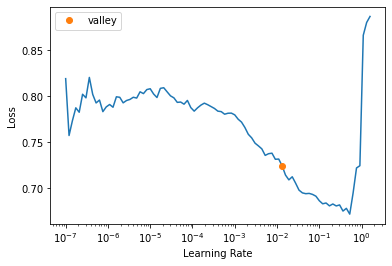

In [261]:
learn.lr_find()

In [262]:
# fine tune the model
learn.fine_tune(5,base_lr = 4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.508178,0.405823,0.803385,01:32


epoch,train_loss,valid_loss,accuracy,time
0,0.351257,0.211600,0.916667,04:12
1,0.223730,0.158402,0.932943,05:40
2,0.177115,0.157924,0.938802,06:48
3,0.155814,0.132222,0.945964,05:59
4,0.128305,0.152827,0.940104,04:11


/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [263]:
learn.save('finetuned')

Path('models/finetuned.pth')

In [264]:
learn = learn.load('finetuned')

In [265]:
# load the test dataloader
dl = learn.dls.test_dl(test['clean_review'])
dl

In [266]:
preds = learn.get_preds(dl=dl)  
preds

(tensor([[9.9168e-01, 8.3171e-03],
         [9.9928e-01, 7.2265e-04],
         [5.6563e-01, 4.3437e-01],
         ...,
         [9.9787e-01, 2.1341e-03],
         [9.8962e-01, 1.0385e-02],
         [2.9198e-01, 7.0802e-01]]),
 None)

In [267]:
sample = "I am really impressed with the battery backup."

In [268]:
import unicodedata as uni
def preprocessing1(text):
    
    text = remove_url(text) 
    text = uni.normalize('NFKD', text)
    text = handle_emoji(text)
    text = text.lower() 
    text = re.sub(r'[^\w\s]', '', text)
    text = word_tokenizer(text)
    # text = stemming(text)
    #text = lemmatization(text)
    #text = remove_stopwords(text)
    text = " ".join(text)

    return text


In [269]:
aspects = ["phone", "camera", "battery", "neutral", "processor"]

def get_similarity(text, aspect):
    try:
        #text = " ".join(text)
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0
    
def best_aspect(text, aspects):
    a = []
    
    for aspect in aspects:
        a.append(get_similarity([text], [aspect]))
    print(a)
    return aspects[np.argmax(a)]
# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
ba = best_aspect(preprocessing1(sample), aspects)
learn = learn.load('finetuned')
dl = learn.dls.test_dl(sample)
preds = learn.get_preds(dl=dl)  
sentiment = preds[0].argmax(dim=-1)
if sentiment == 0:
    sentiment = 'Negatively'
else :
    sentiment = 'Positively'
print(f"The reviewer is talking {sentiment} about the {ba} of the phone in his/her comment")


[0.7550514, 0.73137397, 0.81028104, 0.8110907, 0.6611517]


The reviewer is talking Positively about the neutral of the phone in his/her comment
